<a href="https://colab.research.google.com/github/MohamedAbuAmira/ML-DL-Examples/blob/m/CNN_model_Flowers_Image_classification_with_GPU_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Here I will classify images of flowers by using Keras API
I write this notebook by my hand after compelet my learning journey in ML and DL


# Import TensorFlow and other libraries

In [1]:
pip install -q tf-nightly

     |████████████████████████████████| 325.9MB 51kB/s 
     |████████████████████████████████| 10.6MB 49.5MB/s 
     |████████████████████████████████| 460kB 62.9MB/s 


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# Download and explore the dataset

3,700 photos of flowers
The dataset contains 5 sub-directories, one per class:


#### flower_photo/
  ###### daisy/
  ###### dandelion/
  ###### roses/
  ###### sunflowers/
  ###### tulips/

In [4]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 3s 0us/step


In [5]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [6]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


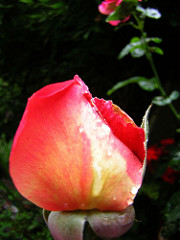

In [7]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

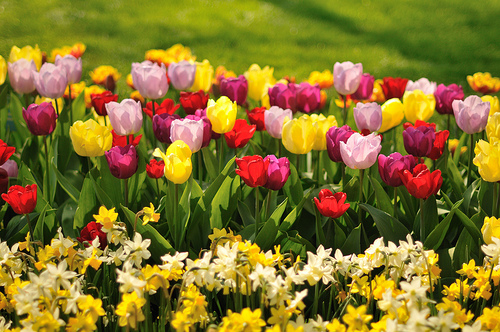

In [8]:
#some tulips
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

# Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility. This will take you from a directory of images on disk to a tf.data.Dataset

## Create a dataset

In [9]:
#some parameters for the loader:

batch_size = 32
img_height = 180
img_width = 180

In [10]:
# We will use 80% of the images for training, and 20% for validation

In [11]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [12]:
print(2936 / 32)
print(len(train_ds))

91.75
92


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [14]:
#You can find the class names in the class_names attribute on these datasets. These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Visualize the data

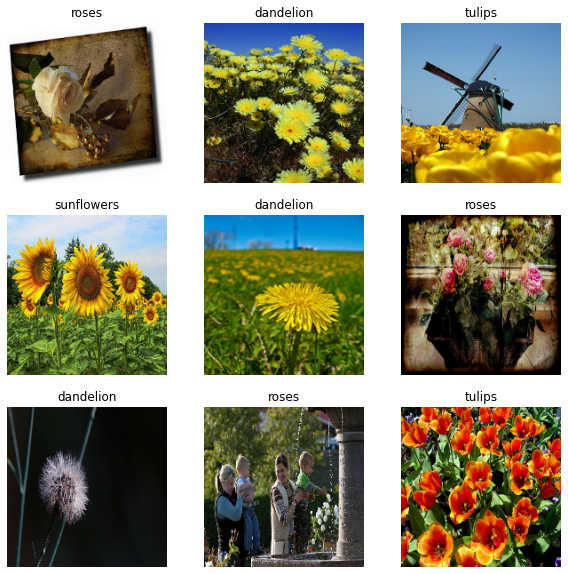

In [15]:
#first 9 images from the training dataset

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [16]:
im=[]
la=[]

In [17]:
for images, labels in train_ds.take(1):
  for i in range(32):
    
    im.append(images[i])
    la.append(class_names[labels[i]])


#take just one batch items,   (images, labels)---32 items--

In [18]:
len(im)

32

In [19]:
len(la)

32

In [20]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [21]:
'''
The image_batch is a tensor of the shape (32, 180, 180, 3). 
This is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). 
The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

You can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray
'''

'\nThe image_batch is a tensor of the shape (32, 180, 180, 3). \nThis is a batch of 32 images of shape 180x180x3 (the last dimension referes to color channels RGB). \nThe label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.\n\nYou can call .numpy() on the image_batch and labels_batch tensors to convert them to a numpy.ndarray\n'

## Configure the dataset for performance

In [22]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

In [23]:
'''
The RGB channel values are in the [0, 255] range.
This is not ideal for a neural network; in general you should seek to make your input values small. 
Here, we will standardize values to be in the [0, 1] by using a Rescaling layer.
'''
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [24]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 1.0


# Create the model


In [25]:
num_classes = 5

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

  
  layers.Conv2D(8, 3, padding='same', activation='relu'),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),

  layers.Flatten(),

  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compile the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 8)       224       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 180, 180, 16)      1168      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 45, 45, 64)        1

## Train the model

In [28]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 9s 103ms/step - loss: 1.5566 - accuracy: 0.2952 - val_loss: 1.1289 - val_accuracy: 0.5082
Epoch 2/10
92/92 [==============================] - 2s 19ms/step - loss: 1.1150 - accuracy: 0.5305 - val_loss: 1.0097 - val_accuracy: 0.6022
Epoch 3/10
92/92 [==============================] - 2s 19ms/step - loss: 0.8585 - accuracy: 0.6686 - val_loss: 0.8227 - val_accuracy: 0.6676
Epoch 4/10
92/92 [==============================] - 2s 19ms/step - loss: 0.7044 - accuracy: 0.7274 - val_loss: 0.8913 - val_accuracy: 0.6649
Epoch 5/10
92/92 [==============================] - 2s 19ms/step - loss: 0.5040 - accuracy: 0.8111 - val_loss: 0.8559 - val_accuracy: 0.6785
Epoch 6/10
92/92 [==============================] - 2s 19ms/step - loss: 0.2790 - accuracy: 0.9045 - val_loss: 0.9908 - val_accuracy: 0.6757
Epoch 7/10
92/92 [==============================] - 2s 19ms/step - loss: 0.1493 - accuracy: 0.9615 - val_loss: 1.2401 - val_accuracy: 0.6785
Epoch 8/10
9

## Visualize training results

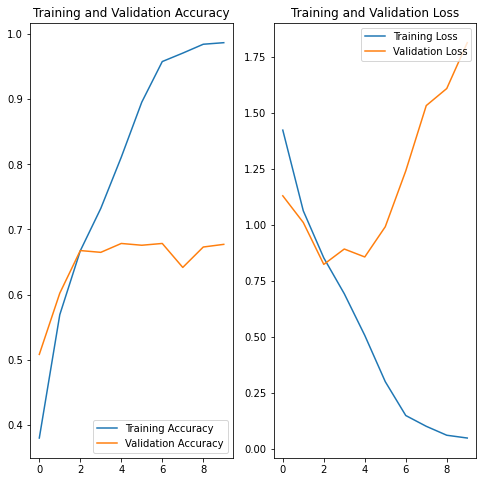

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Overfitting

It means that the model will have a difficult time generalizing on a new dataset

There are multiple ways to fight overfitting in the training process. here I use data augmentation and add Dropout to your model.

### Data augmentation

Overfitting generally occurs when there are a small number of training examples. Data augmentation takes the approach of generating additional training data from your existing examples by augmenting then using random transformations that yield believable-looking images.

In [30]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

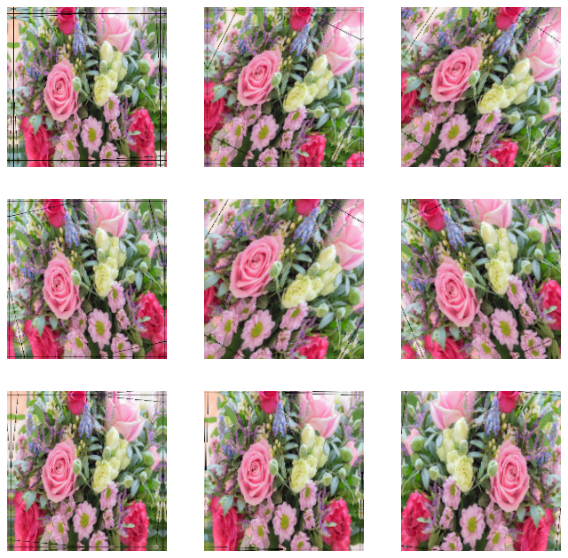

In [31]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

### Dropout

When you apply Dropout to a layer it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

In [53]:
#Let's create a new neural network using layers.Dropout, then train it using augmented images.

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255),

  
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.15),

  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.15),

  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  

  layers.Conv2D(128, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),

  layers.Conv2D(256, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(0.2),
  

  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.Dense(num_classes)
])

### Compile and train the model

In [54]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [55]:
model.summary()


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_6 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 90, 90, 16)        64        
_________________________________________________________________
dropout_11 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 90, 90, 32)       

In [56]:
epochs = 50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
92/92 [==============================] - 3s 35ms/step - loss: 2.5791 - accuracy: 0.4120 - val_loss: 3.2311 - val_accuracy: 0.2398
Epoch 2/50
92/92 [==============================] - 2s 21ms/step - loss: 1.4784 - accuracy: 0.5507 - val_loss: 5.5625 - val_accuracy: 0.2398
Epoch 3/50
92/92 [==============================] - 2s 21ms/step - loss: 1.0066 - accuracy: 0.5991 - val_loss: 3.4283 - val_accuracy: 0.2411
Epoch 4/50
92/92 [==============================] - 2s 21ms/step - loss: 0.8343 - accuracy: 0.6699 - val_loss: 2.7705 - val_accuracy: 0.2888
Epoch 5/50
92/92 [==============================] - 2s 21ms/step - loss: 0.7899 - accuracy: 0.7002 - val_loss: 2.6847 - val_accuracy: 0.3869
Epoch 6/50
92/92 [==============================] - 2s 21ms/step - loss: 0.7680 - accuracy: 0.7054 - val_loss: 1.6078 - val_accuracy: 0.5014
Epoch 7/50
92/92 [==============================] - 2s 21ms/step - loss: 0.6695 - accuracy: 0.7407 - val_loss: 1.4224 - val_accuracy: 0.5300
Epoch 8/50
92

### Visualize training results

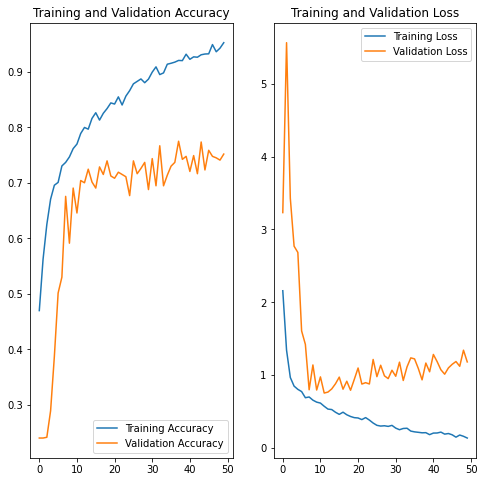

In [57]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Predict on new data

In [63]:
# Finally, let's use our model to classify an image that wasn't included in the training or validation sets

sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


This image most likely belongs to sunflowers with a 99.56 percent confidence.


In [66]:
score

<tf.Tensor: shape=(5,), dtype=float32, numpy=
array([2.9720209e-04, 5.9610151e-04, 2.1722668e-03, 9.9560308e-01,
       1.3312371e-03], dtype=float32)>

In [70]:

!mkdir -p saved_model
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('Flowers Image classification model.h5')

I get some ideas from https://www.tensorflow.org/tutorials/images/classification